# Capstone Project 2
## Predicting Women's Clothing Reviews

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from statsmodels import *
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import spacy
import nltk
nltk.download('stopwords')
from nltk.tokenize.toktok import ToktokTokenizer
import re
from contractions import CONTRACTION_MAP
import unicodedata
import eli5
%matplotlib inline  
pd.set_option('max_columns', 100)

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jupyter/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/usr/local/lib/python3.5/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [4]:
nlp = spacy.load('en_core_web_sm', parse=True, tag=True, entity=True)
#nlp_vec = spacy.load('en_vecs', parse = True, tag=True, entity=True)
tokenizer = ToktokTokenizer()
stopword_list = nltk.corpus.stopwords.words('english')
stopword_list.remove('no')
stopword_list.remove('not')

## Data Cleaning/Wrangling

In [7]:
#importing data
data=pd.read_csv('womens-ecommerce-clothing-reviews (1).zip', index_col=0)
pd.options.display.max_colwidth=0
data.head()

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,767,33,NaN,Absolutely wonderful - silky and sexy and comfortable,4,1,0,Initmates,Intimate,Intimates
1,1080,34,NaN,"Love this dress! it's sooo pretty. i happened to find it in a store, and i'm glad i did bc i never would have ordered it online bc it's petite. i bought a petite and am 5'8"". i love the length on me- hits just a little below the knee. would definitely be a true midi on someone who is truly petite.",5,1,4,General,Dresses,Dresses
2,1077,60,Some major design flaws,"I had such high hopes for this dress and really wanted it to work for me. i initially ordered the petite small (my usual size) but i found this to be outrageously small. so small in fact that i could not zip it up! i reordered it in petite medium, which was just ok. overall, the top half was comfortable and fit nicely, but the bottom half had a very tight under layer and several somewhat cheap (net) over layers. imo, a major design flaw was the net over layer sewn directly into the zipper - it c",3,0,0,General,Dresses,Dresses
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, flirty, and fabulous! every time i wear it, i get nothing but great compliments!",5,1,0,General Petite,Bottoms,Pants
4,847,47,Flattering shirt,This shirt is very flattering to all due to the adjustable front tie. it is the perfect length to wear with leggings and it is sleeveless so it pairs well with any cardigan. love this shirt!!!,5,1,6,General,Tops,Blouses


In [8]:
data.isnull().sum()

Clothing ID                0   
Age                        0   
Title                      3810
Review Text                845 
Rating                     0   
Recommended IND            0   
Positive Feedback Count    0   
Division Name              14  
Department Name            14  
Class Name                 14  
dtype: int64

In [9]:
data['Title']=data['Title'].fillna(" ")

In [10]:
#creating new variable with the title and review text together
data['title_review']=data['Title']+' '+data['Review Text']

In [11]:
data.head()

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name,title_review
0,767,33,,Absolutely wonderful - silky and sexy and comfortable,4,1,0,Initmates,Intimate,Intimates,Absolutely wonderful - silky and sexy and comfortable
1,1080,34,,"Love this dress! it's sooo pretty. i happened to find it in a store, and i'm glad i did bc i never would have ordered it online bc it's petite. i bought a petite and am 5'8"". i love the length on me- hits just a little below the knee. would definitely be a true midi on someone who is truly petite.",5,1,4,General,Dresses,Dresses,"Love this dress! it's sooo pretty. i happened to find it in a store, and i'm glad i did bc i never would have ordered it online bc it's petite. i bought a petite and am 5'8"". i love the length on me- hits just a little below the knee. would definitely be a true midi on someone who is truly petite."
2,1077,60,Some major design flaws,"I had such high hopes for this dress and really wanted it to work for me. i initially ordered the petite small (my usual size) but i found this to be outrageously small. so small in fact that i could not zip it up! i reordered it in petite medium, which was just ok. overall, the top half was comfortable and fit nicely, but the bottom half had a very tight under layer and several somewhat cheap (net) over layers. imo, a major design flaw was the net over layer sewn directly into the zipper - it c",3,0,0,General,Dresses,Dresses,"Some major design flaws I had such high hopes for this dress and really wanted it to work for me. i initially ordered the petite small (my usual size) but i found this to be outrageously small. so small in fact that i could not zip it up! i reordered it in petite medium, which was just ok. overall, the top half was comfortable and fit nicely, but the bottom half had a very tight under layer and several somewhat cheap (net) over layers. imo, a major design flaw was the net over layer sewn directly into the zipper - it c"
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, flirty, and fabulous! every time i wear it, i get nothing but great compliments!",5,1,0,General Petite,Bottoms,Pants,"My favorite buy! I love, love, love this jumpsuit. it's fun, flirty, and fabulous! every time i wear it, i get nothing but great compliments!"
4,847,47,Flattering shirt,This shirt is very flattering to all due to the adjustable front tie. it is the perfect length to wear with leggings and it is sleeveless so it pairs well with any cardigan. love this shirt!!!,5,1,6,General,Tops,Blouses,Flattering shirt This shirt is very flattering to all due to the adjustable front tie. it is the perfect length to wear with leggings and it is sleeveless so it pairs well with any cardigan. love this shirt!!!


In [12]:
data['Class Name'].unique()

array(['Intimates', 'Dresses', 'Pants', 'Blouses', 'Knits', 'Outerwear',
       'Lounge', 'Sweaters', 'Skirts', 'Fine gauge', 'Sleep', 'Jackets',
       'Swim', 'Trend', 'Jeans', 'Legwear', 'Shorts', 'Layering',
       'Casual bottoms', nan, 'Chemises'], dtype=object)

## Exploratory Analysis

In [13]:
#descriptive data on the numerical variables
data.describe()

,Clothing ID,Age,Rating,Recommended IND,Positive Feedback Count
count,23486.000000,23486.000000,23486.000000,23486.000000,23486.000000
mean,918.118709,43.198544,4.196032,0.822362,2.535936
std,203.298980,12.279544,1.110031,0.382216,5.702202
min,0.000000,18.000000,1.000000,0.000000,0.000000
25%,861.000000,34.000000,4.000000,1.000000,0.000000
50%,936.000000,41.000000,5.000000,1.000000,1.000000
75%,1078.000000,52.000000,5.000000,1.000000,3.000000
max,1205.000000,99.000000,5.000000,1.000000,122.000000


In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23486 entries, 0 to 23485
Data columns (total 11 columns):
Clothing ID                23486 non-null int64
Age                        23486 non-null int64
Title                      23486 non-null object
Review Text                22641 non-null object
Rating                     23486 non-null int64
Recommended IND            23486 non-null int64
Positive Feedback Count    23486 non-null int64
Division Name              23472 non-null object
Department Name            23472 non-null object
Class Name                 23472 non-null object
title_review               22641 non-null object
dtypes: int64(5), object(6)
memory usage: 2.2+ MB


[Text(0, 0.5, 'Frequency')]

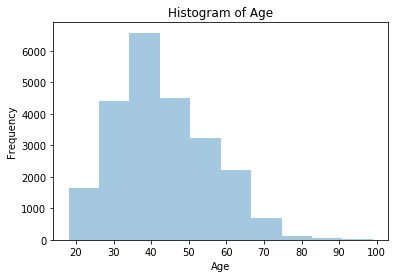

In [15]:
plt.title('Histogram of Age')
ax=sns.distplot(data["Age"],bins=10, kde=False)
ax.set(ylabel='Frequency')

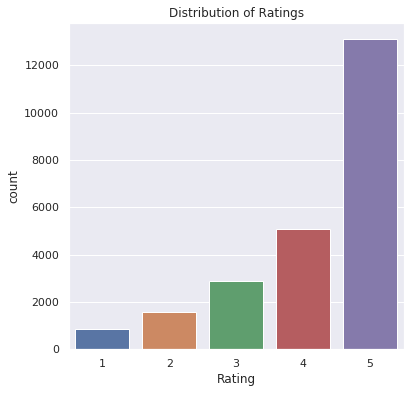

In [16]:
sns.set(rc={'figure.figsize':(6,6)})
plt.title('Distribution of Ratings')
sns.countplot(x = 'Rating', data = data)

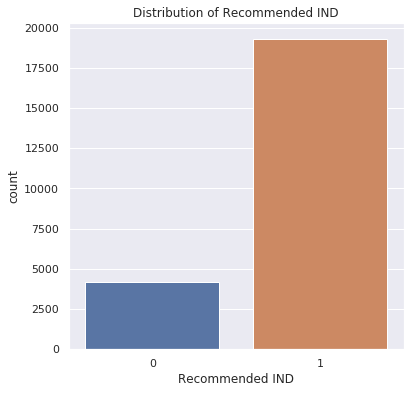

In [17]:
sns.set(rc={'figure.figsize':(6,6)})
plt.title('Distribution of Recommended IND')
sns.countplot(x = 'Recommended IND', data = data)

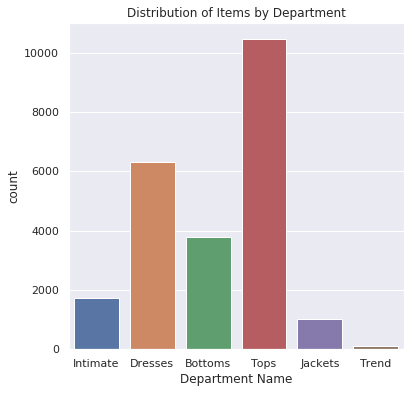

In [18]:
sns.set(rc={'figure.figsize':(6,6)})
plt.title('Distribution of Items by Department')
sns.countplot(x = 'Department Name', data = data)

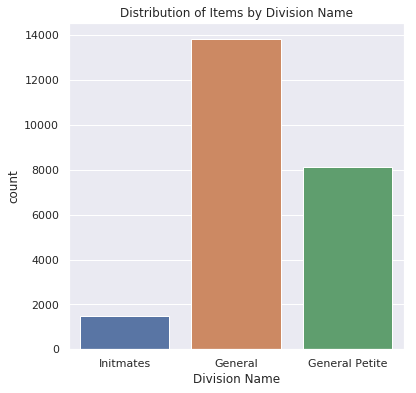

In [19]:
sns.set(rc={'figure.figsize':(6,6)})
plt.title('Distribution of Items by Division Name')
sns.countplot(x = 'Division Name', data = data)

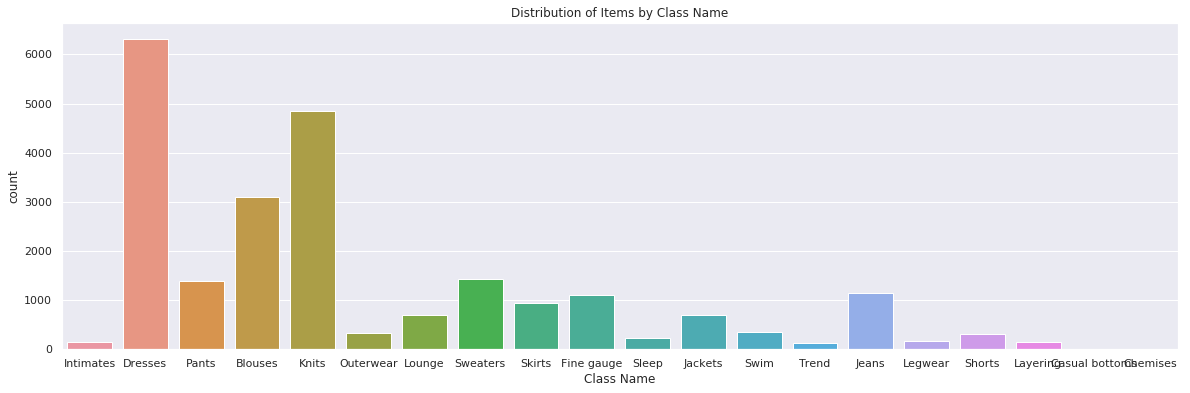

In [20]:
sns.set(rc={'figure.figsize':(20,6)})
plt.title('Distribution of Items by Class Name')
sns.countplot(x = 'Class Name', data = data)

In [21]:
data['Class Name'].value_counts()

Dresses           6319
Knits             4843
Blouses           3097
Sweaters          1428
Pants             1388
Jeans             1147
Fine gauge        1100
Skirts            945 
Jackets           704 
Lounge            691 
Swim              350 
Outerwear         328 
Shorts            317 
Sleep             228 
Legwear           165 
Intimates         154 
Layering          146 
Trend             119 
Casual bottoms    2   
Chemises          1   
Name: Class Name, dtype: int64

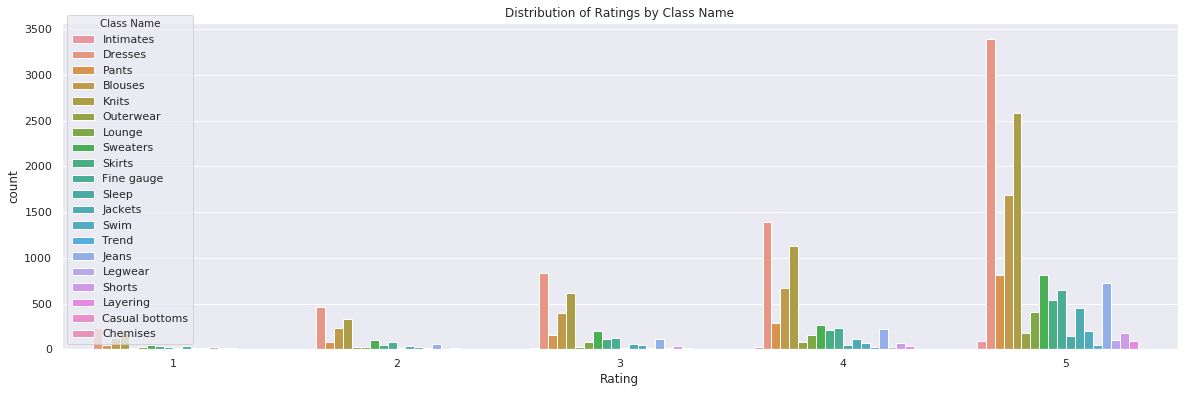

In [22]:
sns.set(rc={'figure.figsize':(20,6)})
plt.title('Distribution of Ratings by Class Name')
sns.countplot(x="Rating", hue="Class Name", data=data)

/usr/local/lib/python3.5/dist-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


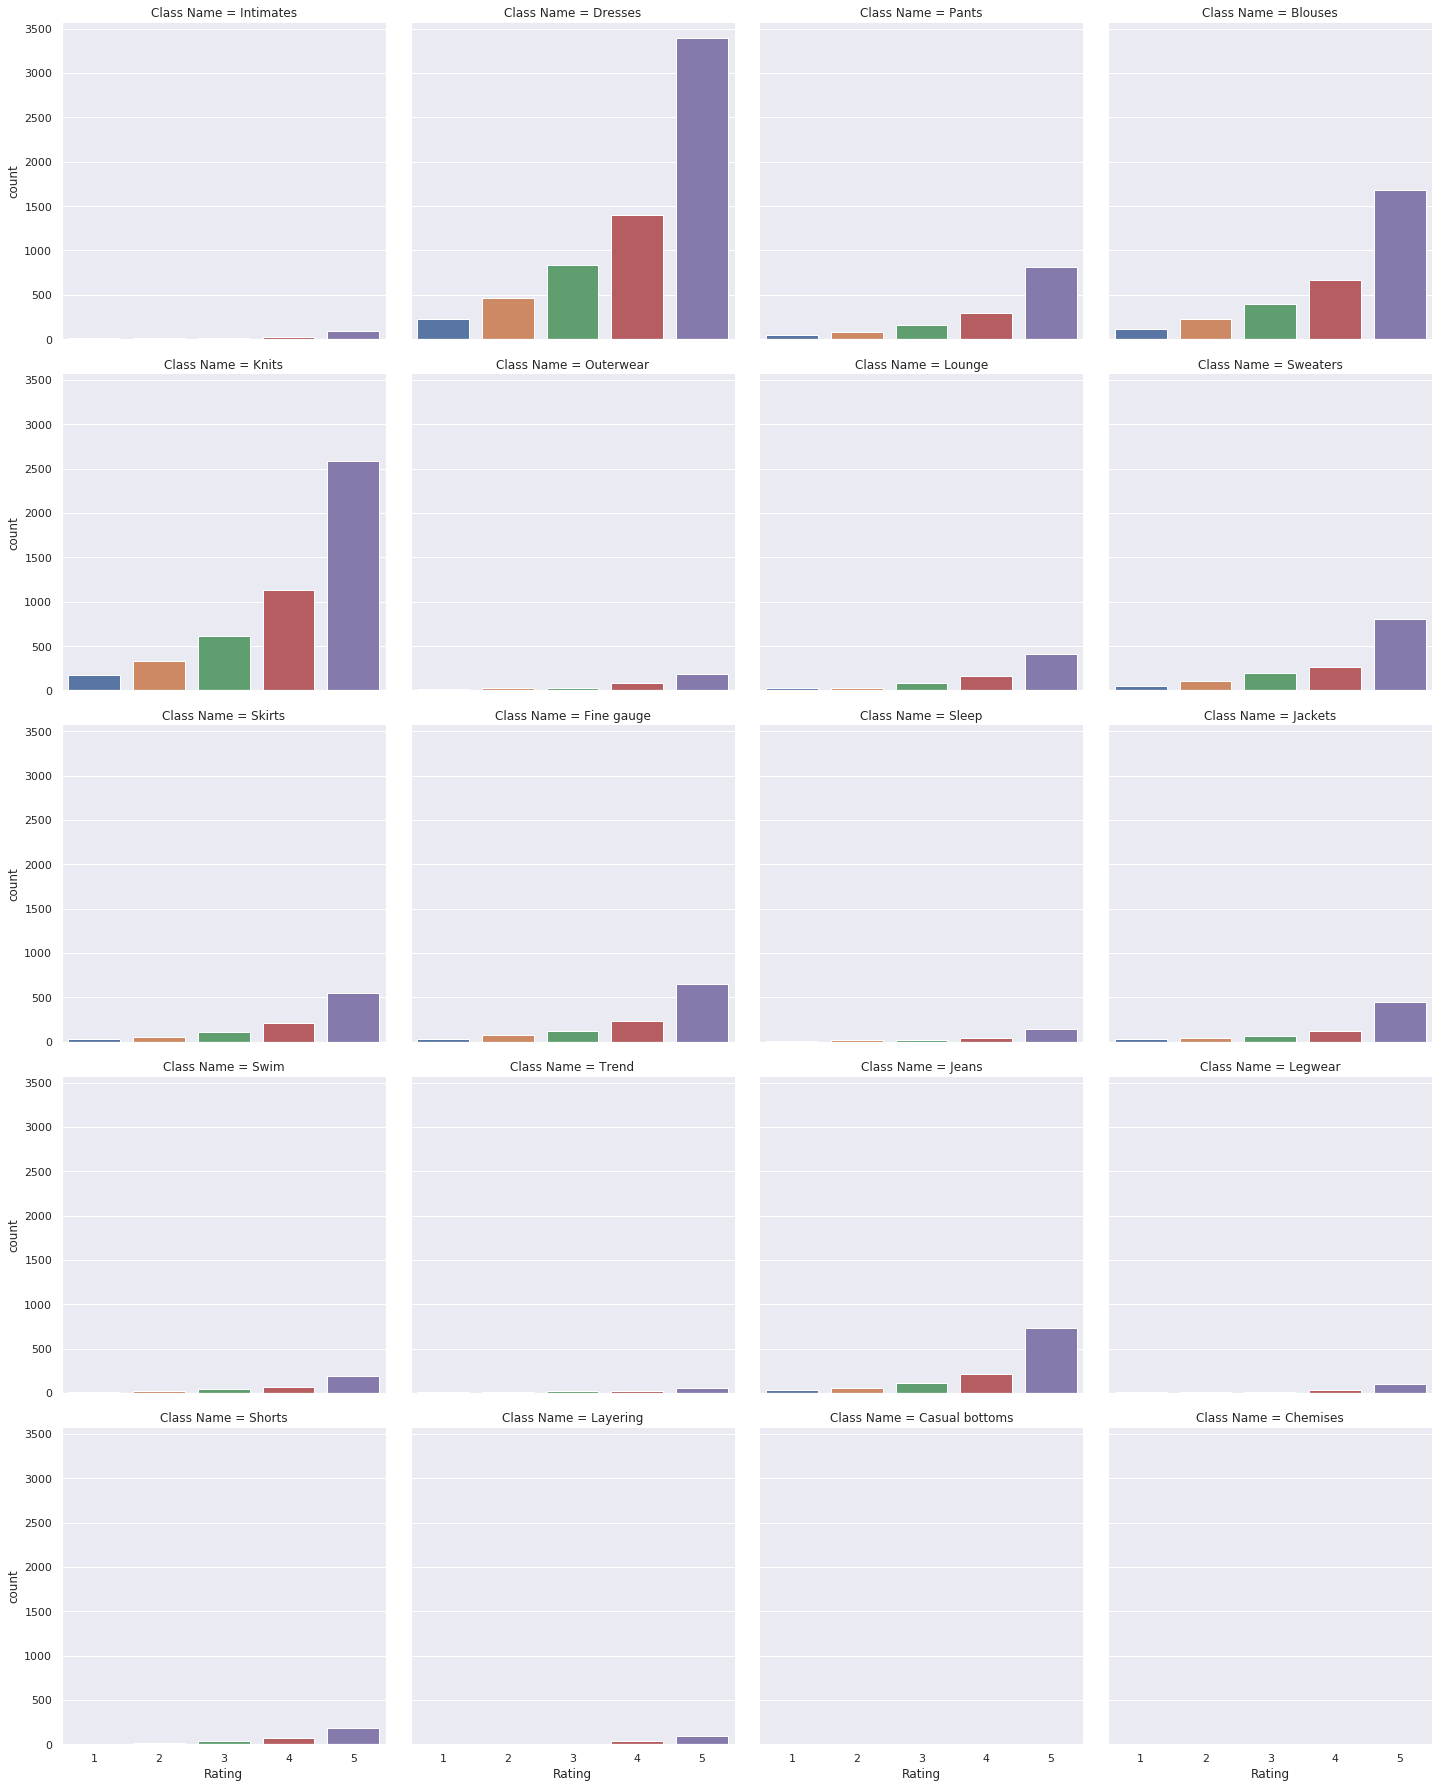

In [23]:
#sns.set(rc={'figure.figsize':(20,6)})
#plt.title('Distribution of Ratings by Class Name')
facetsfc = sns.factorplot(x="Rating", col="Class Name", data=data, col_wrap=4, kind='count')

Text(0, 0.5, 'Count')

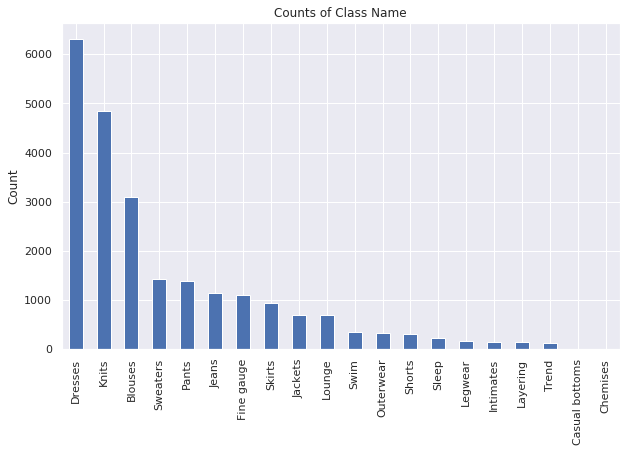

In [24]:
sns.set(rc={'figure.figsize':(10,6)})
ax=data['Class Name'].value_counts().plot(kind='bar')
plt.title('Counts of Class Name')
ax.set_ylabel("Count")


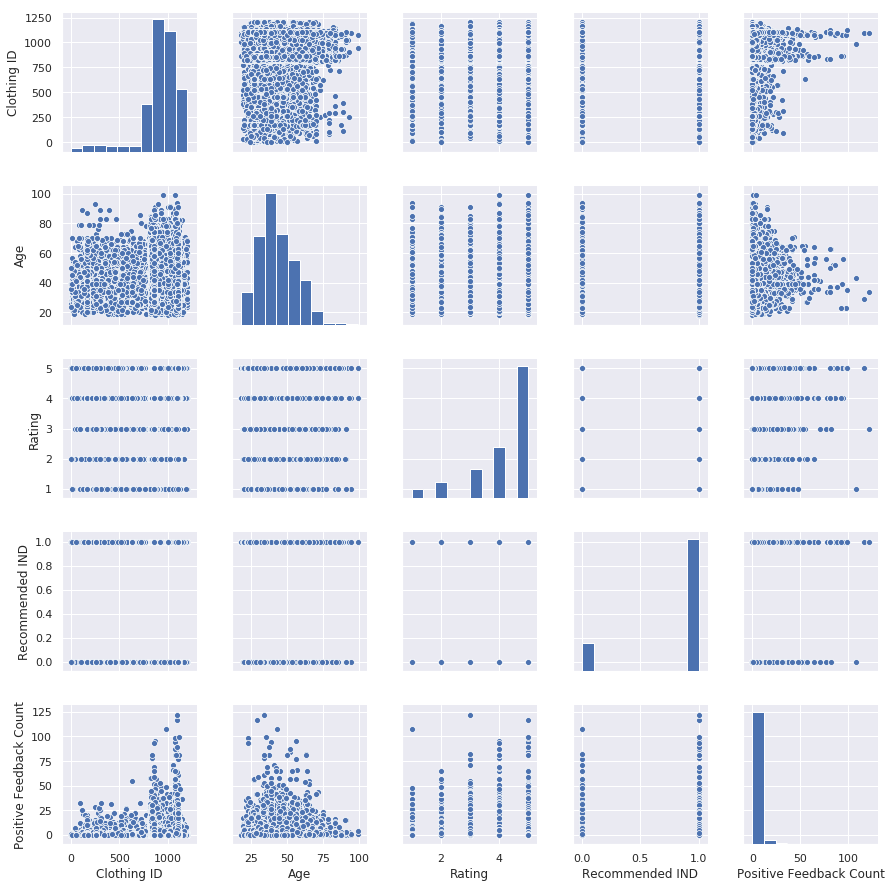

In [25]:
sns.pairplot(data)

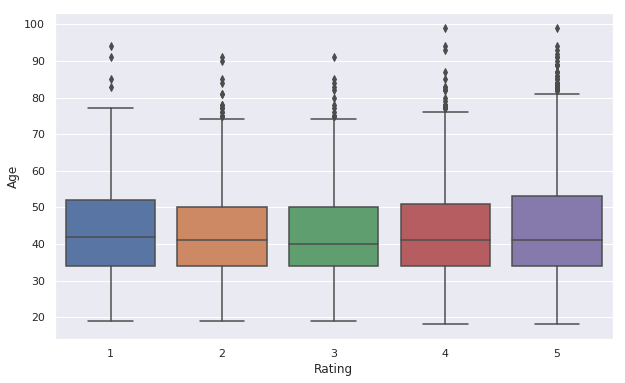

In [26]:
sns.boxplot(x="Rating", y="Age", data=data)

/usr/local/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


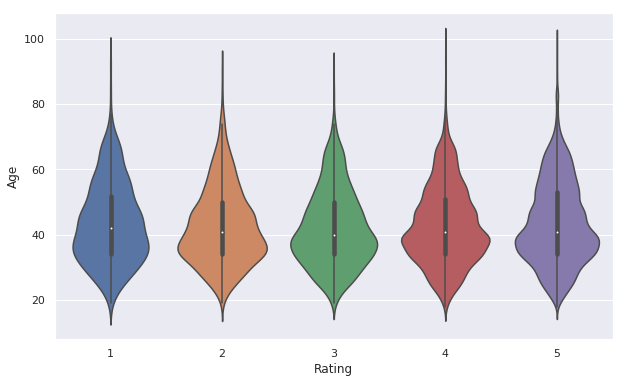

In [27]:
sns.violinplot(x="Rating", y="Age", data=data)

In [28]:
#generate word cloud for all reviews
wordcloud = WordCloud().generate(str(data['title_review']))

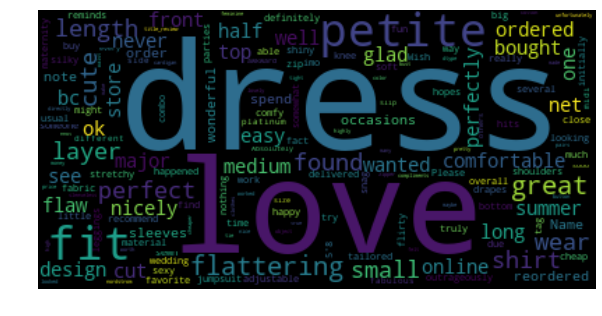

In [29]:
#show word cloud for all reviews
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [30]:
data['rating_type']=data.Rating.apply(lambda x: 'low' if x<3 else 'med' if x==3 else "high")

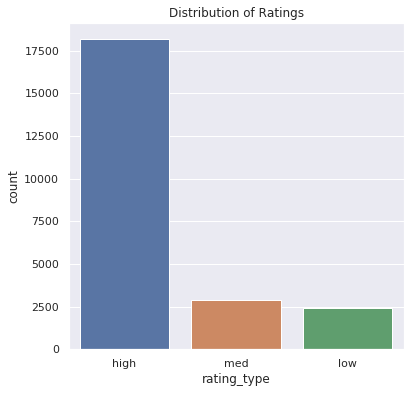

In [31]:
sns.set(rc={'figure.figsize':(6,6)})
plt.title('Distribution of Ratings')
sns.countplot(x = 'rating_type', data = data)

In [32]:
#dropping rows that don't contain any title or review text
data=data.dropna(subset = ['title_review'])

In [33]:
low=" ".join(review for review in data[data["rating_type"]=="low"].title_review)

In [34]:
#generate word cloud for reviews with low ratings
wordcloud_low = WordCloud().generate(low)

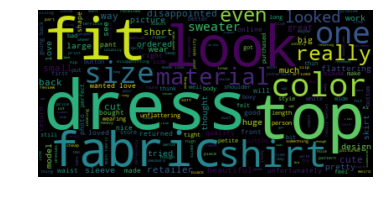

In [35]:
#show word cloud for low ratings
plt.imshow(wordcloud_low, interpolation='bilinear')
plt.axis("off")
plt.show()

In [36]:
high=" ".join(review for review in data[data["rating_type"]=="high"].title_review)

In [37]:
#generate word cloud for reviews with high ratings
wordcloud_high = WordCloud().generate(high)

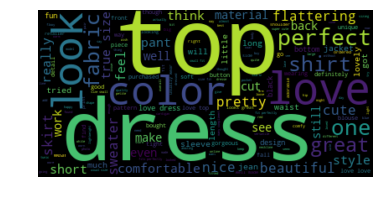

In [38]:
#show word cloud for high ratings
plt.imshow(wordcloud_high, interpolation='bilinear')
plt.axis("off")
plt.show()

## Text Wrangling and Pre-processing

In [39]:
#defining steps of data cleaning

#remove accented characters
def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text

#expand contractions
def expand_contractions(text, contraction_mapping=CONTRACTION_MAP):
    
    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())), 
                                      flags=re.IGNORECASE|re.DOTALL)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match)\
                                if contraction_mapping.get(match)\
                                else contraction_mapping.get(match.lower())                       
        expanded_contraction = first_char+expanded_contraction[1:]
        return expanded_contraction
        
    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text

#removing special characters
def remove_special_characters(text, remove_digits=False):
    pattern = r'[^a-zA-z0-9\s]' if not remove_digits else r'[^a-zA-z\s]'
    text = re.sub(pattern, '', text)
    return text

#stemming words
def simple_stemmer(text):
    ps = nltk.porter.PorterStemmer()
    text = ' '.join([ps.stem(word) for word in text.split()])
    return text

#lemmatizing the text
def lemmatize_text(text):
    text = nlp(text)
    text = ' '.join([word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in text])
    return text

#removing stopwords
def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text

In [40]:
#defining text normalizer
def normalize_corpus(corpus, contraction_expansion=True,
                     accented_char_removal=True, text_lower_case=True, 
                     text_lemmatization=True, special_char_removal=True, 
                     stopword_removal=True, remove_digits=True):
    
    normalized_corpus = []
    # normalize each document in the corpus
    for doc in corpus:
        # remove accented characters
        if accented_char_removal:
            doc = remove_accented_chars(doc)
        # expand contractions    
        if contraction_expansion:
            doc = expand_contractions(doc)
        # lowercase the text    
        if text_lower_case:
            doc = doc.lower()
        # remove extra newlines
        doc = re.sub(r'[\r|\n|\r\n]+', ' ',doc)
        # lemmatize text
        if text_lemmatization:
            doc = lemmatize_text(doc)
        # remove special characters and\or digits    
        if special_char_removal:
            # insert spaces between special characters to isolate them    
            special_char_pattern = re.compile(r'([{.(-)!}])')
            doc = special_char_pattern.sub(" \\1 ", doc)
            doc = remove_special_characters(doc, remove_digits=remove_digits)  
        # remove extra whitespace
        doc = re.sub(' +', ' ', doc)
        # remove stopwords
        if stopword_removal:
            doc = remove_stopwords(doc, is_lower_case=text_lower_case)
            
        normalized_corpus.append(doc)
        
    return normalized_corpus

In [41]:
# pre-process text and store the same
data['clean_text'] = normalize_corpus(data['title_review'])
norm_corpus= list(data['clean_text'])

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [42]:
#preparing data for Machine Learning Models
y=data["rating_type"]
#splitting data into test and training sets
train_corpus, test_corpus, train_labels, test_labels=train_test_split(norm_corpus, y, test_size=0.3, random_state=30)

## Feature Engineering

### Converting to Bag of Words

In [43]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(min_df=0., max_df=1.)
cv_train_features = cv.fit_transform(train_corpus)
cv_test_features=cv.transform(test_corpus)

In [44]:
cv_test_features = cv_test_features.toarray() 
cv_test_features
# get all unique words in the corpus
vocab = cv.get_feature_names()
# show document feature vectors
pd.DataFrame(cv_test_features, columns=vocab)

,aa,aaaaaaamaze,aaaaandido,aaaaannnnnnd,aaaahmaze,aaahe,aame,ab,abbey,abby,abdoman,abdomen,abercrombie,abhor,ability,able,abnormal,abnormally,abo,abroad,abruptly,abs,absence,abso,absolute,absolutely,absolutley,absolutly,absoluty,abstract,absurd,abt,abundance,abundant,ac,acacia,accent,accenting,accentuate,accentuatea,accentuated,accept,acceptabl,acceptable,acceptably,access,accesso,accessories,accessorize,accessory,...,yfit,yield,yike,yikes,yippee,yo,yoga,yogi,yogini,yogis,yoke,yoked,yolk,yoo,yore,york,yoself,young,younger,youre,youth,youthful,yr,yrs,yuck,yucky,yuk,yum,yummy,yummysweater,yup,zag,zara,zermatt,zero,zig,zigzag,zillion,zip,ziploc,zipped,zipper,zippered,zips,zoe,zombie,zone,zoolander,zoom,zowie
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6788,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6789,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6790,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
6791,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Converting to TF-IDF

In [111]:
from sklearn.feature_extraction.text import TfidfVectorizer

tv = TfidfVectorizer(min_df=0., max_df=1., use_idf=True)
tv_train_features = tv.fit_transform(train_corpus)
tv_test_features=tv.transform(test_corpus)
tv_test_features = tv_test_features.toarray() 
pd.DataFrame(tv_test_features)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,...,9877,9878,9879,9880,9881,9882,9883,9884,9885,9886,9887,9888,9889,9890,9891,9892,9893,9894,9895,9896,9897,9898,9899,9900,9901,9902,9903,9904,9905,9906,9907,9908,9909,9910,9911,9912,9913,9914,9915,9916,9917,9918,9919,9920,9921,9922,9923,9924,9925,9926
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.195104,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6788,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6789,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6790,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

## Machine Learning Models

### KNN- Bag of Words

In [46]:
#running KNN model on training data
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn.fit(cv_train_features, train_labels)
knn.score(cv_train_features, train_labels) #accuracy

0.8038238263503281

In [47]:
#running KNN model on test data
knn.score(cv_test_features, test_labels) #accuracy

0.7722655674959518

In [48]:
#confusion matrix
predicted = knn.predict(cv_test_features)
class_labels=knn.classes_
matrix = metrics.confusion_matrix(test_labels, predicted)
matrix_df=pd.DataFrame(matrix, index=class_labels, columns=class_labels)
matrix_df

,high,low,med
high,5092,111,62
low,558,102,36
med,680,100,52


In [49]:
#classification report
from sklearn.metrics import classification_report
print(classification_report(test_labels, predicted))

             precision    recall  f1-score   support

       high       0.80      0.97      0.88      5265
        low       0.33      0.15      0.20       696
        med       0.35      0.06      0.11       832

avg / total       0.70      0.77      0.71      6793



### Logistic Regression- Bag of Words

In [50]:
#running logistic regression model on training data
from sklearn.linear_model import LogisticRegression
logr = LogisticRegression(random_state=5)
logr.fit(cv_train_features, train_labels)
logr.score(cv_train_features, train_labels) #accuracy

0.9279404341241797

In [51]:
#running logistic regression model on test data
logr.score(cv_test_features, test_labels) #accuracy

0.826733402031503

In [52]:
#hyperparameter tuning
from sklearn.model_selection import GridSearchCV

param_grid={'penalty':['l1','l2'], 'C':[.001, .01, 1, 10, 100] } 
grid_search=GridSearchCV(LogisticRegression(random_state=5), param_grid, cv=5)
grid_search.fit(cv_train_features, train_labels)
print("Test set score: {:.3f}".format(grid_search.score(cv_test_features, test_labels)))
print('Best parameters:{}'.format(grid_search.best_params_))
print("Best cross-validation score: {:.3f}".format(grid_search.best_score_))

Test set score: 0.826
Best parameters:{'C': 1, 'penalty': 'l1'}
Best cross-validation score: 0.824


In [53]:
#Score  using best hyperparameters
logr=grid_search.best_estimator_
logr.fit(cv_train_features, train_labels)
logr.score(cv_test_features, test_labels)

0.8255557191226263

In [54]:
#confusion matrix
predicted = logr.predict(cv_test_features)
matrix = metrics.confusion_matrix(test_labels, predicted)
matrix_df=pd.DataFrame(matrix, index=class_labels, columns=class_labels)
matrix_df

,high,low,med
high,5016,69,180
low,183,358,155
med,412,186,234


In [55]:
#classification report
print(classification_report(test_labels, predicted))

             precision    recall  f1-score   support

       high       0.89      0.95      0.92      5265
        low       0.58      0.51      0.55       696
        med       0.41      0.28      0.33       832

avg / total       0.80      0.83      0.81      6793



In [56]:
eli5.show_weights(logr, vec=cv, top=20, target_names=test_labels)

### Linear Support Vector Machine- Bag of Words

In [57]:
#running linear svm model on training data
from sklearn.svm import LinearSVC
svm = LinearSVC(random_state=5)
svm.fit(cv_train_features, train_labels)
svm.score(cv_train_features, train_labels) #accuracy

0.9724886420999496

In [58]:
#running linear svm model on test data
svm.score(cv_test_features, test_labels) #accuracy

0.8062711614897689

In [59]:
#confusion matrix
predicted = svm.predict(cv_test_features)
matrix = metrics.confusion_matrix(test_labels, predicted)
matrix_df=pd.DataFrame(matrix, index=class_labels, columns=class_labels)
matrix_df

,high,low,med
high,4868,119,278
low,157,351,188
med,363,211,258


In [60]:
#classification report
print(classification_report(test_labels, predicted))

             precision    recall  f1-score   support

       high       0.90      0.92      0.91      5265
        low       0.52      0.50      0.51       696
        med       0.36      0.31      0.33       832

avg / total       0.80      0.81      0.80      6793



### Decision Tree- Bag of Words

In [61]:
#running decison tree model on training data
from sklearn.tree import DecisionTreeClassifier
dtree = DecisionTreeClassifier(random_state=5)
dtree.fit(cv_train_features, train_labels)
dtree.score(cv_train_features, train_labels) #accuracy

1.0

In [62]:
#running decision tree model on test data
dtree.score(cv_test_features, test_labels) #accuracy

0.7369350802296482

In [63]:
#confusion matrix
predicted = dtree.predict(cv_test_features)
matrix = metrics.confusion_matrix(test_labels, predicted)
matrix_df=pd.DataFrame(matrix, index=class_labels, columns=class_labels)
matrix_df

,high,low,med
high,4580,283,402
low,293,238,165
med,468,176,188


In [64]:
#classification report
print(classification_report(test_labels, predicted))

             precision    recall  f1-score   support

       high       0.86      0.87      0.86      5265
        low       0.34      0.34      0.34       696
        med       0.25      0.23      0.24       832

avg / total       0.73      0.74      0.73      6793



### Random Forest- Bag of Words

In [65]:
#running Random Forest model on training data
from sklearn.ensemble import RandomForestClassifier
randf = RandomForestClassifier(random_state=5)
randf.fit(cv_train_features, train_labels)
randf.score(cv_train_features, train_labels) #accuracy

0.9863705199394245

In [66]:
#running Random Forest model on test data
randf.score(cv_test_features, test_labels) #accuracy

0.7884587074930075

In [67]:
#confusion matrix
predicted = randf.predict(cv_test_features)
matrix = metrics.confusion_matrix(test_labels, predicted)
matrix_df=pd.DataFrame(matrix, index=class_labels, columns=class_labels)
matrix_df

,high,low,med
high,5190,33,42
low,524,120,52
med,713,73,46


In [68]:
#classification report
print(classification_report(test_labels, predicted))

             precision    recall  f1-score   support

       high       0.81      0.99      0.89      5265
        low       0.53      0.17      0.26       696
        med       0.33      0.06      0.09       832

avg / total       0.72      0.79      0.73      6793



### Gradient Boosting- Bag of Words

In [69]:
#running gradient boosting model on training data
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier(random_state=5)
gb.fit(cv_train_features, train_labels)
gb.score(cv_train_features, train_labels) #accuracy

0.8225012619888945

In [70]:
#running gradient boosting model on test data
gb.score(cv_test_features, test_labels) #accuracy

0.8047990578536729

In [71]:
#confusion matrix
predicted = gb.predict(cv_test_features)
matrix = metrics.confusion_matrix(test_labels, predicted)
matrix_df=pd.DataFrame(matrix, index=class_labels, columns=class_labels)
matrix_df

,high,low,med
high,5188,17,60
low,428,190,78
med,641,102,89


In [72]:
#classification report
print(classification_report(test_labels, predicted))

             precision    recall  f1-score   support

       high       0.83      0.99      0.90      5265
        low       0.61      0.27      0.38       696
        med       0.39      0.11      0.17       832

avg / total       0.75      0.80      0.76      6793



### KNN- TF-IDF

In [73]:
#running KNN model on training data
knn = KNeighborsClassifier()
knn.fit(tv_train_features, train_labels)
knn.score(tv_train_features, train_labels) #accuracy

0.8314613831398284

In [74]:
#running KNN model on test data
knn.score(tv_test_features, test_labels) #accuracy

0.7896363904018843

In [75]:
#confusion matrix
predicted = knn.predict(tv_test_features)
class_labels=knn.classes_
matrix = metrics.confusion_matrix(test_labels, predicted)
matrix_df=pd.DataFrame(matrix, index=class_labels, columns=class_labels)
matrix_df

,high,low,med
high,5101,70,94
low,435,182,79
med,649,102,81


In [76]:
#classification report
print(classification_report(test_labels, predicted))

             precision    recall  f1-score   support

       high       0.82      0.97      0.89      5265
        low       0.51      0.26      0.35       696
        med       0.32      0.10      0.15       832

avg / total       0.73      0.79      0.74      6793



### Logistic Regression- TF-IDF

In [77]:
#running logistic regression model on training data
logr = LogisticRegression(random_state=5)
logr.fit(tv_train_features, train_labels)
logr.score(tv_train_features, train_labels) #accuracy

0.8584048460373549

In [78]:
#running logistic regression model on test data
logr.score(tv_test_features, test_labels) #accuracy

0.8265861916678934

In [79]:
#hyperparameter tuning

param_grid={'penalty':['l1','l2'], 'C':[.001, .01, 1, 10, 100]} 
grid_search=GridSearchCV(LogisticRegression(random_state=5), param_grid, cv=5)
grid_search.fit(tv_train_features, train_labels)
print("Test set score: {:.3f}".format(grid_search.score(tv_test_features, test_labels)))
print('Best parameters:{}'.format(grid_search.best_params_))
print("Best cross-validation score: {:.3f}".format(grid_search.best_score_))

Test set score: 0.830
Best parameters:{'C': 10, 'penalty': 'l2'}
Best cross-validation score: 0.827


In [80]:
#Score  using best hyperparameters
logr=grid_search.best_estimator_
logr.fit(tv_train_features, train_labels)
logr.score(tv_test_features, test_labels)

0.8301192403945238

In [81]:
#confusion matrix
predicted = logr.predict(tv_test_features)
matrix = metrics.confusion_matrix(test_labels, predicted)
matrix_df=pd.DataFrame(matrix, index=class_labels, columns=class_labels)
matrix_df

,high,low,med
high,5038,62,165
low,184,354,158
med,406,179,247


In [82]:
#classification report
print(classification_report(test_labels, predicted))

             precision    recall  f1-score   support

       high       0.90      0.96      0.92      5265
        low       0.59      0.51      0.55       696
        med       0.43      0.30      0.35       832

avg / total       0.81      0.83      0.82      6793



In [83]:
eli5.show_weights(logr, vec=tv, top=20, target_names=test_labels)

### Linear Support Vector Machine- TF-IDF

In [84]:
#running linear svm model on training data
svm = LinearSVC(random_state=5)
svm.fit(tv_train_features, train_labels)
svm.score(tv_train_features, train_labels) #accuracy

0.9316633013629481

In [85]:
#running linear svm model on test data
svm.score(tv_test_features, test_labels) #accuracy

0.8279110849403798

In [86]:
#hyperparameter tuning

param_grid={'class_weight':['balanced', None], 'C':[.001, .01, 1, 10, 100, 1000] } 
grid_search=GridSearchCV(LinearSVC(random_state=5), param_grid, cv=5)
grid_search.fit(tv_train_features, train_labels)
print("Test set score: {:.3f}".format(grid_search.score(tv_test_features, test_labels)))
print('Best parameters:{}'.format(grid_search.best_params_))
print("Best cross-validation score: {:.3f}".format(grid_search.best_score_))

Test set score: 0.828
Best parameters:{'C': 1, 'class_weight': None}
Best cross-validation score: 0.826


In [87]:
#Score  using best hyperparameters
svm=grid_search.best_estimator_
svm.fit(tv_train_features, train_labels)
svm.score(tv_test_features, test_labels)

0.8279110849403798

In [88]:
#confusion matrix
predicted = svm.predict(tv_test_features)
matrix = metrics.confusion_matrix(test_labels, predicted)
matrix_df=pd.DataFrame(matrix, index=class_labels, columns=class_labels)
matrix_df

,high,low,med
high,5026,72,167
low,180,365,151
med,403,196,233


In [89]:
#classification report
print(classification_report(test_labels, predicted))

             precision    recall  f1-score   support

       high       0.90      0.95      0.92      5265
        low       0.58      0.52      0.55       696
        med       0.42      0.28      0.34       832

avg / total       0.81      0.83      0.81      6793



In [90]:

# get array of feature importances
svm.coef_

array([[ 5.74428044e-01,  3.52988122e-01, -8.67361738e-19, ...,
         0.00000000e+00, -2.18053189e-01,  0.00000000e+00],
       [ 1.04121168e-01,  0.00000000e+00,  0.00000000e+00, ...,
         1.40914466e-01,  5.78159552e-01,  0.00000000e+00],
       [-4.61803038e-01, -3.68428632e-01,  0.00000000e+00, ...,
        -3.12142490e-01, -1.93862635e-01,  0.00000000e+00]])

In [91]:
import eli5

In [107]:
eli5.show_weights(svm, vec=tv, top=10, target_names=test_labels)

### Decision Tree- TF-IDF

In [93]:
#running decison tree model on training data
dtree = DecisionTreeClassifier(random_state=5)
dtree.fit(tv_train_features, train_labels)
dtree.score(tv_train_features, train_labels) #accuracy

1.0

In [94]:
#running decision tree model on test data
dtree.score(tv_test_features, test_labels) #accuracy

0.734432504048285

In [95]:
#confusion matrix
predicted = dtree.predict(tv_test_features)
matrix = metrics.confusion_matrix(test_labels, predicted)
matrix_df=pd.DataFrame(matrix, index=class_labels, columns=class_labels)
matrix_df

,high,low,med
high,4558,271,436
low,288,235,173
med,455,181,196


In [96]:
#classification report
print(classification_report(test_labels, predicted))

             precision    recall  f1-score   support

       high       0.86      0.87      0.86      5265
        low       0.34      0.34      0.34       696
        med       0.24      0.24      0.24       832

avg / total       0.73      0.73      0.73      6793



### Random Forest- TF-IDF

In [97]:
#running Random Forest model on training data
randf = RandomForestClassifier(random_state=5)
randf.fit(tv_train_features, train_labels)
randf.score(tv_train_features, train_labels) #accuracy

0.9844775365976779

In [98]:
#running Random Forest model on test data
randf.score(tv_test_features, test_labels) #accuracy

0.7900780214927131

In [99]:
#confusion matrix
predicted = randf.predict(tv_test_features)
matrix = metrics.confusion_matrix(test_labels, predicted)
matrix_df=pd.DataFrame(matrix, index=class_labels, columns=class_labels)
matrix_df

,high,low,med
high,5203,27,35
low,526,108,62
med,706,70,56


In [100]:
#classification report
print(classification_report(test_labels, predicted))

             precision    recall  f1-score   support

       high       0.81      0.99      0.89      5265
        low       0.53      0.16      0.24       696
        med       0.37      0.07      0.11       832

avg / total       0.73      0.79      0.73      6793



### Gradient Boosting- TF-IDF

In [101]:
#running gradient boosting model on training data
gb = GradientBoostingClassifier(random_state=5)
gb.fit(tv_train_features, train_labels)
gb.score(tv_train_features, train_labels) #accuracy

0.8308303886925795

In [102]:
#running gradient boosting model on test data
gb.score(tv_test_features, test_labels) #accuracy

0.8046518474900634

In [103]:
#confusion matrix
predicted = gb.predict(tv_test_features)
matrix = metrics.confusion_matrix(test_labels, predicted)
matrix_df=pd.DataFrame(matrix, index=class_labels, columns=class_labels)
matrix_df

,high,low,med
high,5193,21,51
low,434,182,80
med,652,89,91


In [104]:
#classification report
print(classification_report(test_labels, predicted))

             precision    recall  f1-score   support

       high       0.83      0.99      0.90      5265
        low       0.62      0.26      0.37       696
        med       0.41      0.11      0.17       832

avg / total       0.76      0.80      0.76      6793

